In [1]:
# !pip install catboost xgboost

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluations
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Models hyperparameter tuning
from sklearn.model_selection import GridSearchCV 

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./dataset/cleaned_data_mining_water_table.csv')

In [4]:
random_seed = 42
y = df['status_group']
x = df.drop(columns=['status_group'])

x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=0.2, random_state=random_seed)

---
## <ins>Predictive Model Building</ins>

## Custom Functions

In [5]:
def model_evaluations(model):
    # Record the training and testing set's performance
    y_pred_train = model.predict(x_train)
    y_pred = model.predict(x_test)

    # Display training and testing set's accuracy
    print("Accuracy score train: {}%".format(accuracy_score(y_train, y_pred_train)))
    print("Accuracy score test: {}%".format(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

    classes=['Functional', 'Functional needs repair', 'Non functional']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.tight_layout()
    plt.show()

In [6]:
def model_feature_importances(model, title):
    # Sort the features
    sorted_idx = model.feature_importances_.argsort()

    # Display the plot
    plt.barh(x_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel(title)

## 1. Default Models Overview

In [7]:
models = [\
          LogisticRegression(random_state=random_seed),
          DecisionTreeClassifier(random_state=random_seed),
          RandomForestClassifier(random_state=random_seed),
          KNeighborsClassifier(),
          CatBoostClassifier(random_state=random_seed),
          XGBClassifier(random_state=random_seed)
         ]

model_names = [\
               'Logistic Regression',
               'Decision Tree Classifier',
               'Random Forest Classifier',
               'KNN Classifier',
               'Catboost Classifier',
               'XGB Classifier'
              ]

accuracy = []
mean_accuracy = []
std = []

# Perform n-fold cross validation across all the models and record the accuracy and std of the accuracy
for model in models:
    cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)
    n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    accuracy.append(n_scores)
    mean_score = np.mean(n_scores)
    std_score = np.std(n_scores)
    mean_accuracy.append(mean_score)
    std.append(std_score)

In [8]:
df_score = pd.DataFrame({'Model': model_names, 'Accuracy': mean_accuracy, 'Std': std})
df_score = df_score.sort_values('Accuracy', ascending=True)
df_score[['Model', 'Accuracy', 'Std']]

,Model,Accuracy,Std
0,Logistic Regression,0.629024,0.009345
1,Decision Tree Classifier,0.755960,0.004994
3,KNN Classifier,0.767290,0.005665
4,Catboost Classifier,0.793990,0.004015
5,XGB Classifier,0.798047,0.004722
2,Random Forest Classifier,0.807475,0.003940


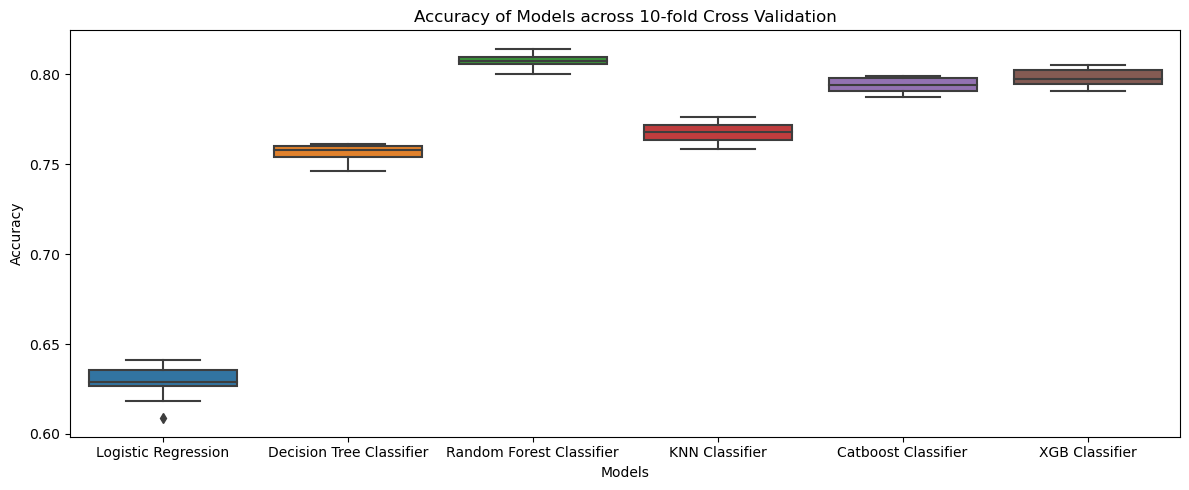

In [9]:
plt.subplots(figsize=(12, 5))
sns.boxplot(data=accuracy)
plt.xticks(range(0, len(model_names)), model_names)
plt.title('Accuracy of Models across 10-fold Cross Validation')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

### 2. Hyperparameter Tuning (CatBoost, XGBoost, RandomForestClassifier)

In [10]:
selected_models = [\
                   CatBoostClassifier(random_state=random_seed),
                   XGBClassifier(random_state=random_seed),
                   RandomForestClassifier(random_state=random_seed),
                  ]

selected_model_names = [\
                        'Catboost Classifier',
                        'XGB Classifier', 
                        'Random Forest Classifier',
                       ]

param_grid_models = [\
                     # Catboost Classifier's Parameter Search Grids
                     {\
                      'random_state': [random_seed],
                      'max_depth' : np.arange(6, 12, 2).tolist(),
                      'iterations': np.arange(700, 1000, 150).tolist()
                     },
                     # XGB Classifier's Parameter Search Grids
                     {\
                     'random_state': [random_seed],
                     'n_estimators': np.arange(150, 250, 25).tolist(),
                     'max_depth':  np.arange(6, 12, 2).tolist(),
                     'colsample_bytree': [0.3],
                     'eta': [0.2],
                     },
                     # Random Forest Classifier's Parameter Search Grids
                     {\
                      'random_state': [random_seed],
                      'n_estimators': np.arange(150, 250, 25).tolist(),
                      'max_features': ['log2'],
                      'max_depth' : np.arange(20, 60, 10).tolist()
                     },
                    ]

f_search = []

# Perform hyperparameter tuning on the model candidate
for index in range(len(selected_models)):
    f_model_search = GridSearchCV(selected_models[index], param_grid=param_grid_models[index], 
                                  n_jobs=-1, scoring='accuracy', verbose=0)
    
    # Involves only the training set in hyperparameter tuning
    f_model_search.fit(x_train, y_train)
    f_search.append(f_model_search)

Learning rate set to 0.110531
0:	learn: 1.0219158	total: 160ms	remaining: 2m 15s
1:	learn: 0.9608919	total: 182ms	remaining: 1m 17s
2:	learn: 0.9126198	total: 205ms	remaining: 58s
3:	learn: 0.8724746	total: 229ms	remaining: 48.4s
4:	learn: 0.8409183	total: 250ms	remaining: 42.3s
5:	learn: 0.8138035	total: 270ms	remaining: 38s
6:	learn: 0.7908334	total: 290ms	remaining: 34.9s
7:	learn: 0.7711133	total: 313ms	remaining: 32.9s
8:	learn: 0.7537422	total: 333ms	remaining: 31.1s
9:	learn: 0.7387263	total: 352ms	remaining: 29.5s
10:	learn: 0.7259302	total: 372ms	remaining: 28.3s
11:	learn: 0.7147657	total: 392ms	remaining: 27.4s
12:	learn: 0.7049037	total: 412ms	remaining: 26.6s
13:	learn: 0.6957177	total: 434ms	remaining: 25.9s
14:	learn: 0.6883927	total: 456ms	remaining: 25.4s
15:	learn: 0.6811655	total: 477ms	remaining: 24.8s
16:	learn: 0.6750926	total: 496ms	remaining: 24.3s
17:	learn: 0.6695397	total: 517ms	remaining: 23.9s
18:	learn: 0.6644365	total: 537ms	remaining: 23.5s
19:	learn: 0.

In [11]:
for index in range(len(selected_model_names)):
    print(selected_model_names[index])
    print('Best parametes:', f_search[index].best_params_)
    print('Accuracy: {:.2f}%\n'.format(f_search[index].best_score_ * 100))

Catboost Classifier
Best parametes: {'iterations': 850, 'max_depth': 8, 'random_state': 42}
Accuracy: 79.80%

XGB Classifier
Best parametes: {'colsample_bytree': 0.3, 'eta': 0.2, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42}
Accuracy: 80.32%

Random Forest Classifier
Best parametes: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 225, 'random_state': 42}
Accuracy: 80.56%



**Best Hyperparameters:**

Catboost Classifier
Best parametes: {'iterations': 850, 'max_depth': 8, 'random_state': 42}
Accuracy: 79.80%

XGB Classifier
Best parametes: {'colsample_bytree': 0.3, 'eta': 0.2, 'max_depth': 10, 'n_estimators': 150, 'random_state': 42}
Accuracy: 80.34%

Random Forest Classifier
Best parametes: {'max_depth': 20, 'max_features': 'log2', 'n_estimators': 225, 'random_state': 42}
Accuracy: 80.56%


### 2.1 CatBoost

Learning rate set to 0.110531
0:	learn: 1.0219158	total: 24.1ms	remaining: 20.5s
1:	learn: 0.9608919	total: 45.5ms	remaining: 19.3s
2:	learn: 0.9126198	total: 67.7ms	remaining: 19.1s
3:	learn: 0.8724746	total: 89.3ms	remaining: 18.9s
4:	learn: 0.8409183	total: 111ms	remaining: 18.8s
5:	learn: 0.8138035	total: 134ms	remaining: 18.9s
6:	learn: 0.7908334	total: 158ms	remaining: 19s
7:	learn: 0.7711133	total: 178ms	remaining: 18.7s
8:	learn: 0.7537422	total: 201ms	remaining: 18.8s
9:	learn: 0.7387263	total: 225ms	remaining: 18.9s
10:	learn: 0.7259302	total: 248ms	remaining: 18.9s
11:	learn: 0.7147657	total: 273ms	remaining: 19.1s
12:	learn: 0.7049037	total: 294ms	remaining: 18.9s
13:	learn: 0.6957177	total: 315ms	remaining: 18.8s
14:	learn: 0.6883927	total: 336ms	remaining: 18.7s
15:	learn: 0.6811655	total: 358ms	remaining: 18.7s
16:	learn: 0.6750926	total: 380ms	remaining: 18.6s
17:	learn: 0.6695397	total: 400ms	remaining: 18.5s
18:	learn: 0.6644365	total: 421ms	remaining: 18.4s
19:	learn

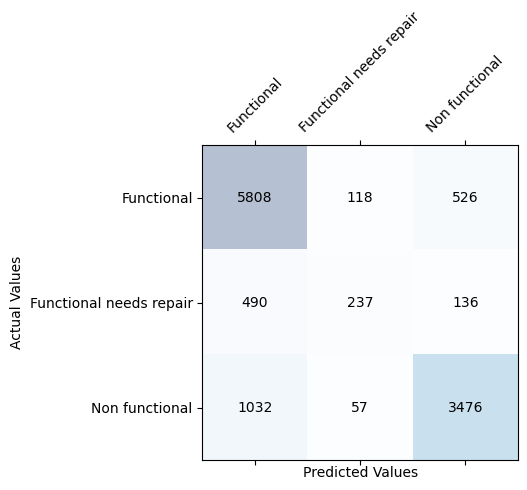

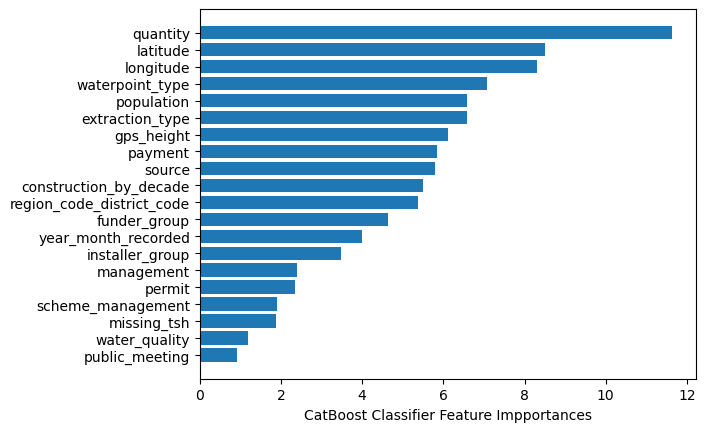

In [12]:
cbc = CatBoostClassifier(**f_search[0].best_params_)
cbc.fit(x_train, y_train)

model_evaluations(cbc)
model_feature_importances(cbc, 'CatBoost Classifier Feature Impportances')

### 2.2 XGB

Accuracy score train: 0.9261574074074074%
Accuracy score test: 0.8111111111111111%
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      6452
           1       0.62      0.27      0.38       863
           2       0.85      0.77      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.76      0.65      0.68     11880
weighted avg       0.81      0.81      0.80     11880



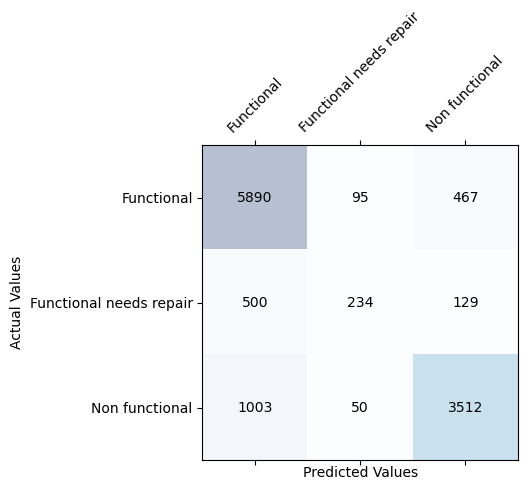

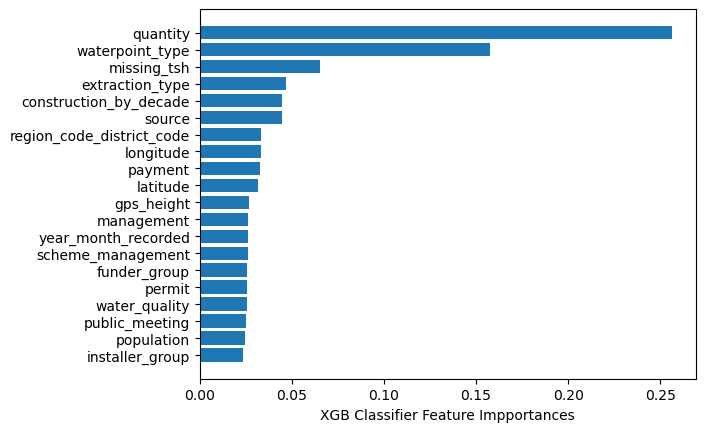

In [13]:
xgbc = XGBClassifier(**f_search[1].best_params_)
xgbc.fit(x_train, y_train)

model_evaluations(xgbc)
model_feature_importances(xgbc, 'XGB Classifier Feature Impportances')

### 2.3 Random Forest

Accuracy score train: 0.9496001683501684%
Accuracy score test: 0.8079124579124579%
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      6452
           1       0.60      0.28      0.38       863
           2       0.85      0.77      0.81      4565

    accuracy                           0.81     11880
   macro avg       0.75      0.65      0.68     11880
weighted avg       0.80      0.81      0.80     11880



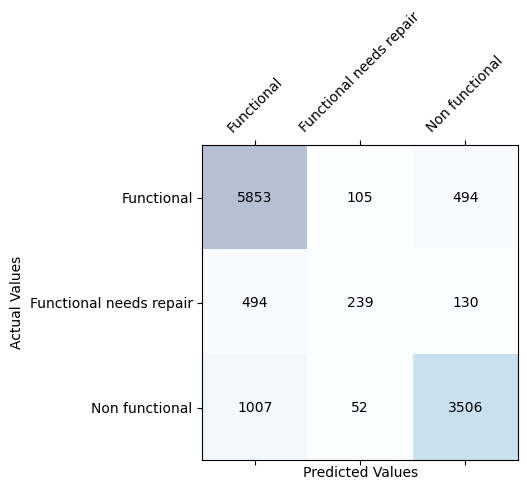

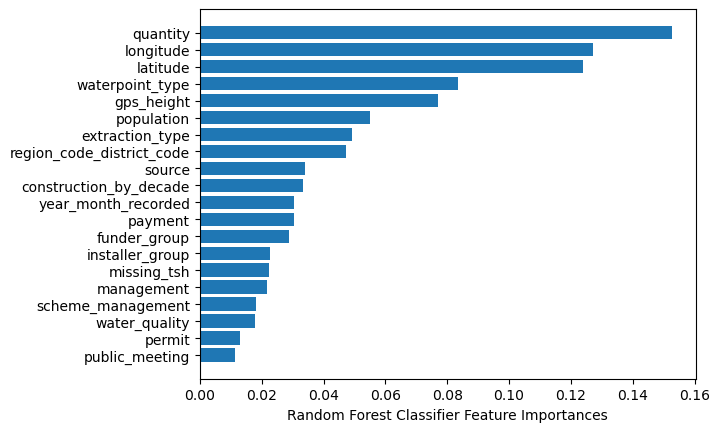

In [14]:
rfc = RandomForestClassifier(**f_search[2].best_params_)
rfc.fit(x_train, y_train)

model_evaluations(rfc)
model_feature_importances(rfc, 'Random Forest Classifier Feature Importances')